# Cross-Validation & Grid Search

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/loans.csv',
                 usecols=[
                     'SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
                     'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                     'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE'
                 ], index_col='SK_ID_CURR')
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE
SK_ID_CURR,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0


In [3]:
df['TARGET'].value_counts(normalize=True)

0    0.905533
1    0.094467
Name: TARGET, dtype: float64

## Feature Extraction / Transformations

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder

y = df.pop('TARGET')
ct = ColumnTransformer(
    [('l_enc', OneHotEncoder(), ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']),
     ('scaler', 'passthrough', ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_CHILDREN'])]
)

X = ct.fit_transform(df)

## Conventional Stratified Splitting

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, stratify=y)

In [6]:
from sklearn.tree import DecisionTreeClassifier

In [7]:
dt = DecisionTreeClassifier()

In [8]:
dt.fit(xtrain, ytrain)

DecisionTreeClassifier()

### Scoring on training data

In [9]:
roc_auc_score(ytrain, dt.predict(xtrain))

0.9178037896915217

### Scoring on testing data

In [10]:
roc_auc_score(ytest, dt.predict(xtest))

0.49882658286172865

In [11]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, stratify=y, shuffle=True)  # shuffle=True is default
dt.fit(xtrain, ytrain)
print('Train score:', roc_auc_score(ytrain, dt.predict(xtrain)))
print('Test score:', roc_auc_score(ytest, dt.predict(xtest)))

Train score: 0.9157019983185669
Test score: 0.5026794609750046


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

### Let's do it ten times

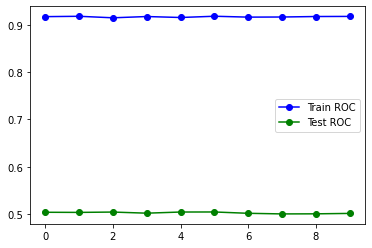

In [13]:
train_scores = []
test_scores = []
for i in range(10):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, stratify=y, shuffle=True)  # shuffle=True is default
    dt.fit(xtrain, ytrain)
    train_scores.append(roc_auc_score(ytrain, dt.predict(xtrain)))
    test_scores.append(roc_auc_score(ytest, dt.predict(xtest)))
plt.plot(train_scores, '-bo', label='Train ROC')
plt.plot(test_scores, '-go', label='Test ROC')
plt.legend()

## K-Fold Cross Validation

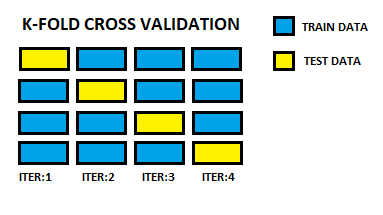

In [14]:
from IPython.display import Image
Image(filename='assets/kfold.png')

In [15]:
from sklearn.model_selection import StratifiedKFold

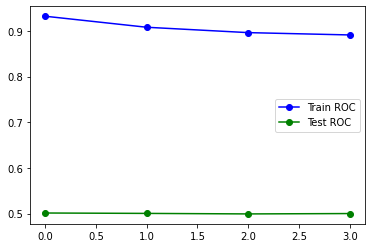

In [16]:
skf = StratifiedKFold(n_splits=4)
train_scores = []
test_scores = []
for train_ix, test_ix in skf.split(X, y):
    xtrain, xtest, ytrain, ytest = X[train_ix], X[test_ix], y.iloc[train_ix], y.iloc[test_ix]
    dt.fit(xtrain, ytrain)
    train_scores.append(roc_auc_score(ytrain, dt.predict(xtrain)))
    test_scores.append(roc_auc_score(ytest, dt.predict(xtest)))
plt.plot(train_scores, '-bo', label='Train ROC')
plt.plot(test_scores, '-go', label='Test ROC')
plt.legend()

### Remember that we haven't touched the model yet!

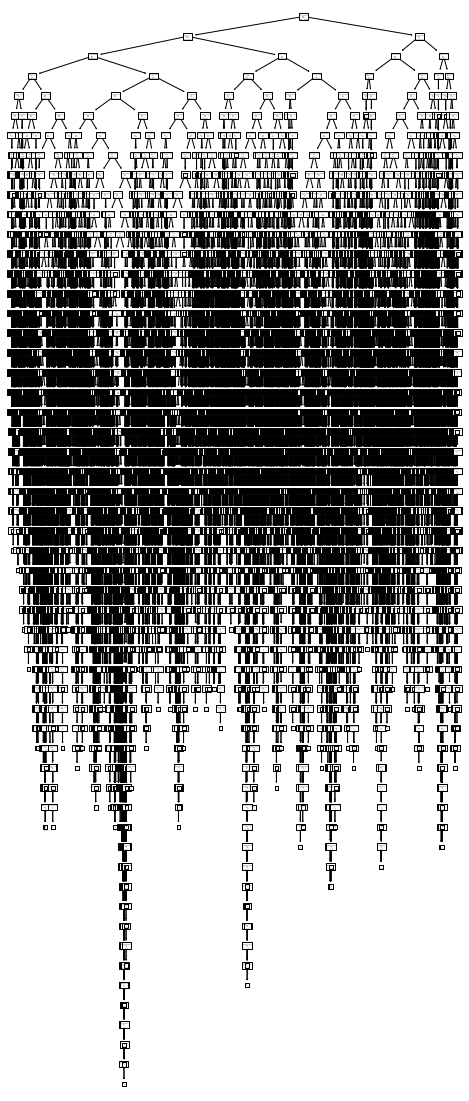

In [17]:
from IPython.display import Image
Image(filename='assets/tree.png') 

## Grid Search

In [18]:
from sklearn.model_selection import GridSearchCV
grid = {
    'criterion': ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'max_depth': [10, 20, 30, 40, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 3, 4, 5],
    'class_weight': ['balanced']
}

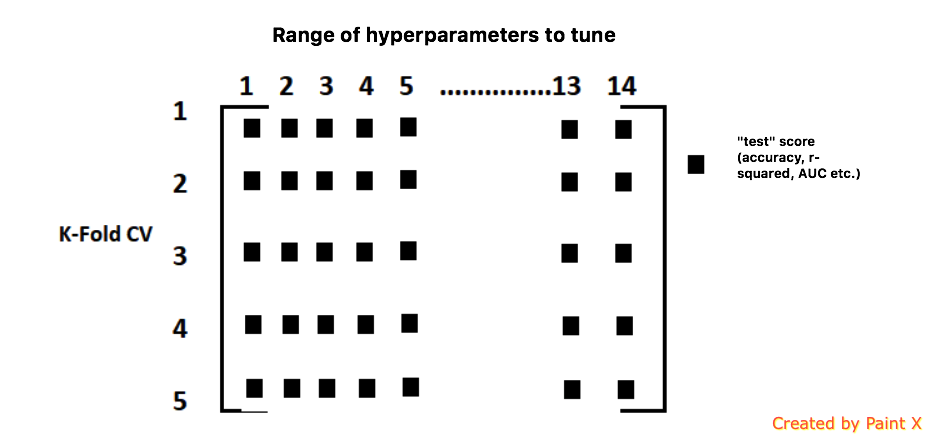

In [19]:
Image(filename='assets/grid_search.png') 

In [20]:
gcv = GridSearchCV(DecisionTreeClassifier(), grid, scoring='roc_auc', cv=4, n_jobs=-1, verbose=2)

In [22]:
gcv.fit(X, y)

Fitting 4 folds for each of 240 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   54.6s finished


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30, 40, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 3, 4, 5],
                         'splitter': ['best', 'random']},
             scoring='roc_auc', verbose=2)

In [23]:
gcv.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_split': 3,
 'splitter': 'best'}

In [24]:
dt_best = gcv.best_estimator_

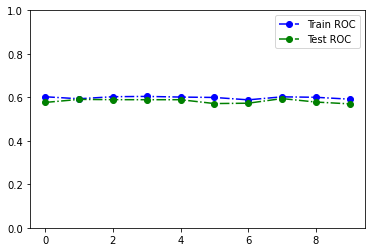

In [25]:
skf = StratifiedKFold(n_splits=10)
train_scores = []
test_scores = []
for train_ix, test_ix in skf.split(X, y):
    xtrain, xtest, ytrain, ytest = X[train_ix], X[test_ix], y.iloc[train_ix], y.iloc[test_ix]
    dt_best.fit(xtrain, ytrain)
    train_scores.append(roc_auc_score(ytrain, dt_best.predict(xtrain)))
    test_scores.append(roc_auc_score(ytest, dt_best.predict(xtest)))
plt.plot(train_scores, '-.bo', label='Train ROC')
plt.plot(test_scores, '-.go', label='Test ROC')
plt.ylim(0, 1)
plt.legend()

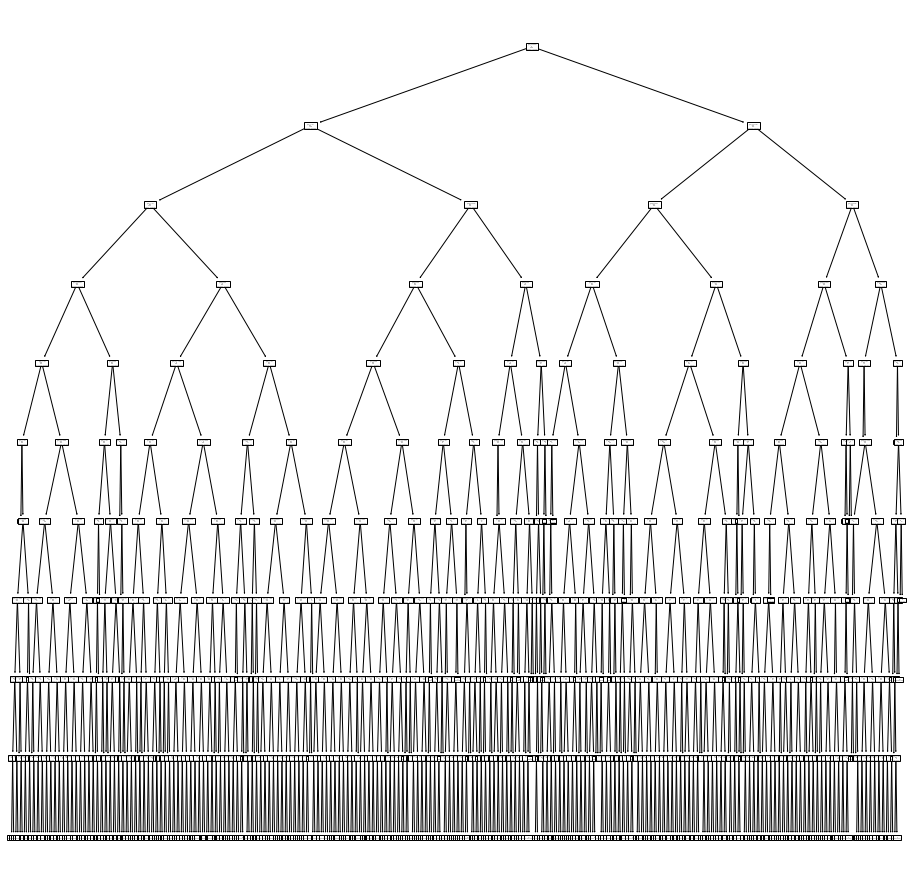

In [26]:
Image(filename='assets/best-tree.png')